In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path
import h5py
from scipy.io import savemat
import scipy.integrate as integrate
from skimage import exposure
from skimage import filters
from scipy import stats
from scipy.io import readsav


from src.data.file_utils import GetTV


In [8]:
flatten = lambda x : x.reshape(len(x), -1)

def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def crop_time(times, data, start_time, end_time):
    """Crop the data to the specified time range."""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    start_idx = nearest_index(times, start_time)
    end_idx = nearest_index(times, end_time)
    return times[start_idx:end_idx], data[:,start_idx:end_idx]

def get_index(arr, coord):
    # Get the insertion indices
    ind = np.searchsorted(coord, arr)

    # Correct the indices to point to the nearest actual index
    ind = np.clip(ind, 0, len(coord) - 1)

    # Now, adjust the indices to get the closest value
    for i, cval in enumerate(arr):
        if ind[i] > 0 and abs(cval - coord[ind[i] - 1]) < abs(cval - coord[ind[i]]):
            ind[i] -= 1
            
    return ind

In [9]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 2
        var = 5
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.001
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = tuple(np.random.randint(0, i, int(num_salt)) for i in image.shape)
        out[coords] = 210
        # Pepper mode
        # num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        # coords = tuple(np.random.randint(0, i, int(num_pepper)) for i in image.shape)
        # out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        num,row,col = image.shape
        gauss = np.random.randn(num,row,col)
        gauss = gauss.reshape(num,row,col)        
        noisy = image + image * gauss * .15
        return noisy

In [10]:
tv = GetTV('../data/raw/tv_images/all')
files = tv.list_files()
for idx, file in enumerate(files):
    print(idx, '\t',file.stem.split('_')[-1])

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354


In [11]:
file_idx = 0
print('Extracting sav for shot:', files[file_idx].stem.split('_')[-1])

[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
inverted_times = vid_times[frames.astype(int)]
inverted_dim = inverted.shape
if (inverted_dim[1] != 201) or (inverted_dim[2] != 201):
    print('Resizing...')
    inverted = inverted[:,:201,:201]
    radii = radii[:,:201]
    elevation = elevation[:,:201]
    inverted_dim = inverted.shape

Extracting sav for shot: 189057


### Aza's Pickle

In [12]:
# specifically for aza pickle (don't use if different)
files_path = Path('../data/raw/tv_images/aza').rglob('*.pkl')
files_aza = sorted([f for f in files_path])
for idx, file in enumerate(files_aza):
    print(idx, '\t',file.stem.split('_')[-1])

0 	 200896
1 	 200897
2 	 200898
3 	 200902
4 	 200910
5 	 200912
6 	 200913
7 	 200916
8 	 200919
9 	 200920
10 	 200921
11 	 200922
12 	 200923
13 	 200924
14 	 200925
15 	 200926
16 	 200927
17 	 200928
18 	 200929
19 	 200930
20 	 200931
21 	 200932
22 	 200933
23 	 200934
24 	 200935
25 	 200936
26 	 200937
27 	 200950
28 	 200951
29 	 200952
30 	 200953
31 	 200954
32 	 200956
33 	 200957
34 	 200958
35 	 200964
36 	 200968
37 	 200969
38 	 200970
39 	 200971
40 	 200972
41 	 200973
42 	 200974
43 	 200975
44 	 200976
45 	 200977
46 	 200978


In [13]:
total_aza_vid = []
for file in files_aza[35:]:
    with open(file, 'rb') as f:
        frames_vid_aza, times_vid = pickle.load(open(file, 'rb'),encoding='latin1')
        frames_vid_aza = np.round(frames_vid_aza * (255.0/1000.0)).astype('uint8')[:,::2,:]
        total_aza_vid.append(frames_vid_aza)
total_aza_vid = np.vstack(total_aza_vid)

KeyboardInterrupt: 

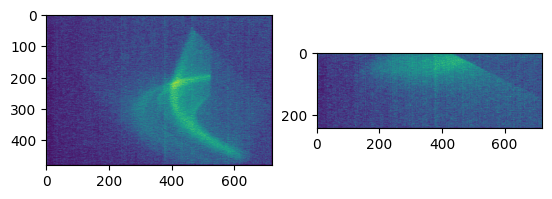

In [94]:
file_idx_aza = 35
frames_vid_aza, times_vid = pickle.load(open(files_aza[file_idx_aza], 'rb'),encoding='latin1')

plt.subplot(1,2,1)
plt.imshow(frames_vid_aza[45])

frames_vid_aza = np.round(frames_vid_aza * (255.0/1000.0)).astype('uint8')[:,::2,:]

plt.subplot(1,2,2)
plt.imshow(frames_vid_aza[-90])

In [168]:
def compute_histograms(image_array, num_bins=256):
    N = image_array.shape[0]
    histograms = []
    for i in range(N):
        image = image_array[i]
        hist, bin_edges = np.histogram(image.ravel(), bins=num_bins, range=(0, 1), density=False)
        histograms.append(hist)
    return histograms, bin_edges

def compute_average_histogram(histograms):
    sum_hist = np.sum(histograms, axis=0)
    avg_hist = sum_hist / np.sum(sum_hist)
    return avg_hist

# Step 2: Compute the CDF of the average histogram
def compute_cdf(hist):
    cdf = np.cumsum(hist)
    cdf_normalized = cdf / cdf[-1]
    return cdf_normalized

# Step 3: Match images to the average histogram
def match_image_to_histogram(image, target_cdf, bin_edges):
    src_hist, _ = np.histogram(image.ravel(), bins=bin_edges, density=False)
    src_cdf = np.cumsum(src_hist)
    src_cdf_normalized = src_cdf / src_cdf[-1]
    interp_values = np.interp(src_cdf_normalized, target_cdf, bin_edges[:-1])
    matched_image = np.interp(image.ravel(), bin_edges[:-1], interp_values)
    return matched_image.reshape(image.shape)

def match_images_to_histogram(image_array, target_cdf, bin_edges):
    M = image_array.shape[0]
    matched_images = np.empty_like(image_array)
    for i in range(M):
        matched_images[i] = match_image_to_histogram(image_array[i], target_cdf, bin_edges)
    return matched_images * 255

In [185]:
images_N = frames_vid_aza.astype(np.float32)[45:-90] / 255.0
vid_noisy = noisy('speckle', vid)
images_M = vid_noisy.astype(np.float32) / 255.0

# Compute the average histogram
histograms, bin_edges = compute_histograms(images_N)
avg_hist = compute_average_histogram(histograms)
target_cdf = compute_cdf(avg_hist)

# save target_cdf, bin_edges to numpy
np.save('target_cdf.npy', target_cdf)
np.save('bin_edges.npy', bin_edges)

# load target_cdf, bin_edges from numpy
target_cdf = np.load('target_cdf.npy')
bin_edges = np.load('bin_edges.npy')

In [176]:
matched_images = match_images_to_histogram(images_M, target_cdf, bin_edges)

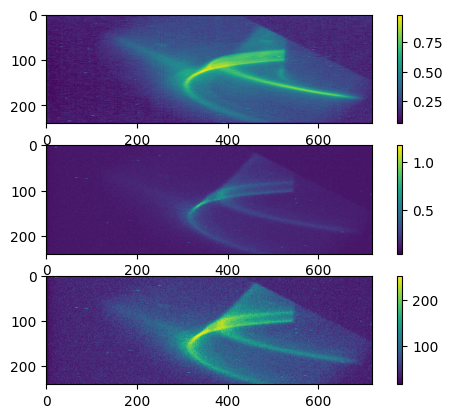

In [181]:
plt.subplot(3,1,1)
plt.imshow(images_N[90])
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(images_M[90])
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(matched_images[90])
plt.colorbar()

In [25]:
index_dict = {
            "inverted": 0,
            "radii": 1,
            "elevation": 2,
            "frames": 3,
            "times": 4,
            "vid_frames": 5,
            "vid_times": 6,
            "vid": 7,
        }
dat_path = '/scratch/gpfs/nc1514/plasma-tv/data/raw/tv_images/filippo_dat/cam240perp_200978_f207_t3366.6247_1.dat'
data_dat = readsav(dat_path)

In [71]:
keys = ['inversion', 'camimage', 'virtimage', 'camera', 'shot', 'time', 'img_r', 'img_z']
inve_, cam_, virt_, cam, shot, time, img_r, img_z = [data_dat[key] for key in keys]

In [72]:
print(time)

3366.6247438932023


In [78]:
(-1.072 - (-1.039)) / (-1.072 + 1.24477)

-0.191005382878973

-1.0391298514234562


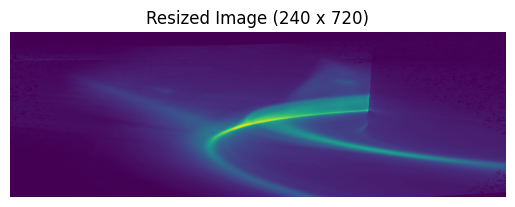

In [77]:
from skimage.transform import resize

# Resize the image to 240 x 720
cam_resized = resize(virt_, (240, 720), anti_aliasing=True)
cam_rotate = np.flip(np.rot90(np.rot90(cam_resized)), axis=1)

with open('/scratch/gpfs/nc1514/plasma-tv/models/092324_tangtv_v2.txt', "r") as file:
    coef = file.readlines()
z_coef_ = np.array([float(i) for i in coef])
inter_ = -1.1381
cam_flatten = cam_rotate.reshape(-1)
pred_point = np.dot(z_coef_, cam_flatten) + inter_
print(pred_point)
# Display the resized image
plt.imshow(cam_rotate)
plt.title('Resized Image (240 x 720)')
plt.axis('off')
plt.show()

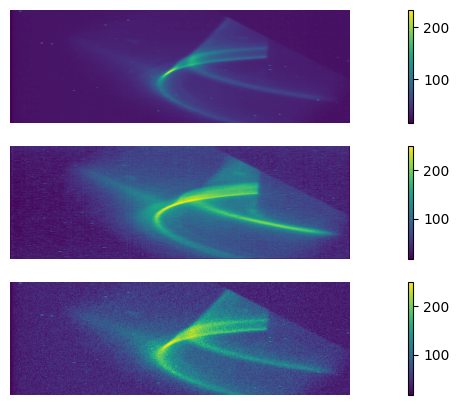

In [184]:
edit_img = vid[90].copy()
# edit_image = noisy('speckle', edit_img)
# edit_image = exposure.match_histograms(edit_image, frames_vid_aza[90])

cdf_aza = np.cumsum(frames_vid_aza[90].ravel())
cdf_edit = np.cumsum(edit_image.ravel())

plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.imshow(vid[90])
plt.axis('off')
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(frames_vid_aza[90])
plt.axis('off')
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(edit_image)
plt.axis('off')
plt.colorbar()
plt.show()

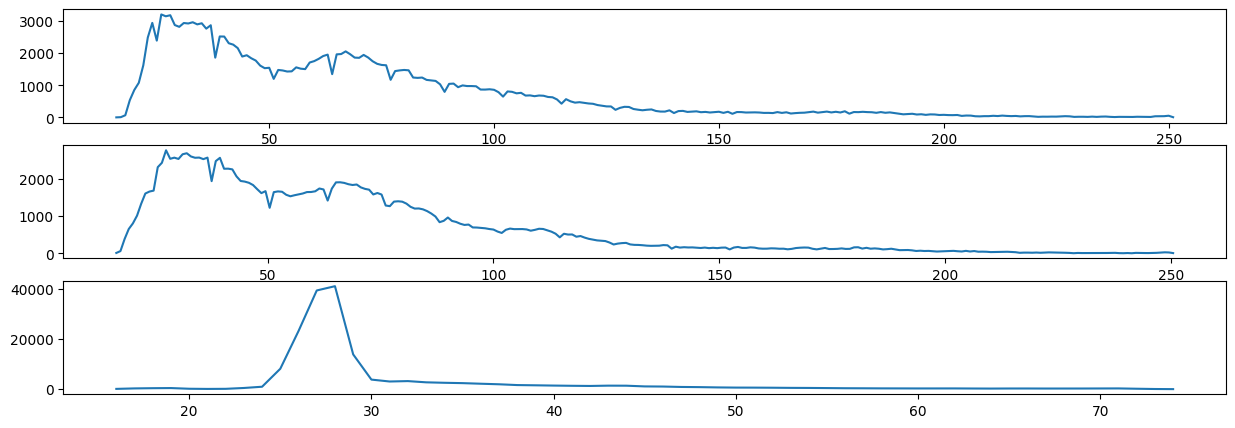

In [65]:
aza_hist = exposure.histogram(frames_vid_aza[140])
edit_hist = exposure.histogram(edit_image)
vid_hist = exposure.histogram(vid[50])

plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.plot(aza_hist[1], aza_hist[0])
plt.subplot(3,1,2)
plt.plot(edit_hist[1], edit_hist[0])
plt.subplot(3,1,3)
plt.plot(vid_hist[1], vid_hist[0])
plt.show()

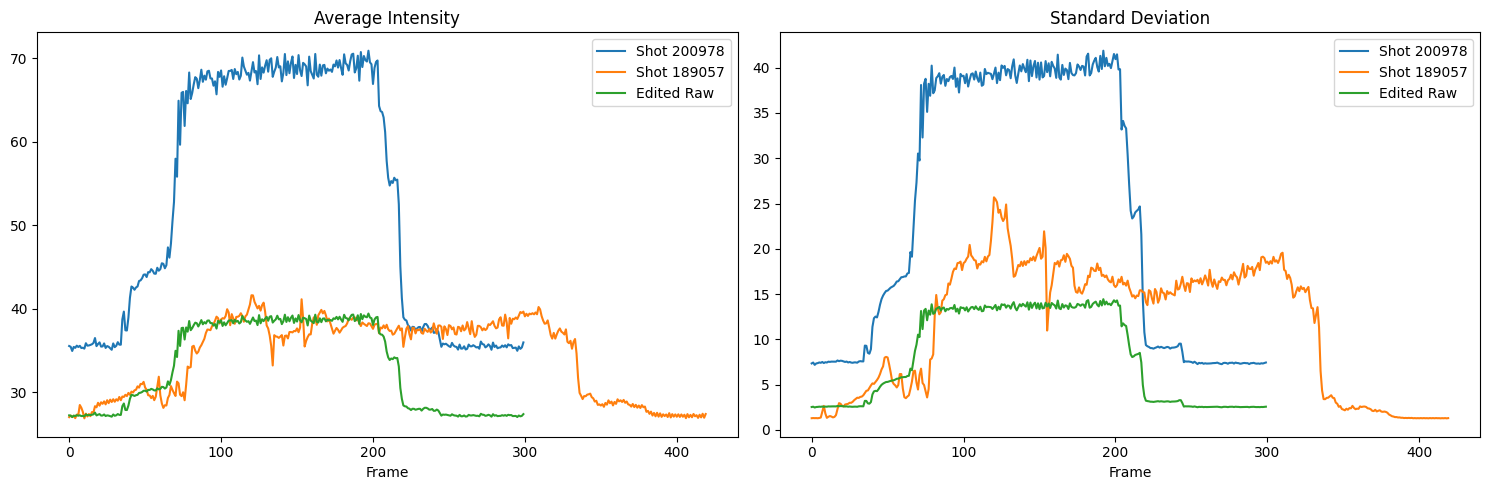

In [11]:
# Normalize the 'frames_vid_aza' array
aza_min = np.min(frames_vid_aza, axis=(1,2), keepdims=True)
aza_max = np.max(frames_vid_aza, axis=(1,2), keepdims=True)

# Compute the average of the normalized 'edit_aza'
avg_edit_aza = np.mean(edit_vid, axis=(1,2))
# Compute the average of the original 'frames_vid_aza'
avg_aza = np.mean(frames_vid_aza, axis=(1,2))
# Compute the average values across the last two axes (1 and 2)
avg_vid = np.mean(vid, axis=(1,2))
# Compute the average values across the last two axes (1 and 2)
std_aza_vid = np.std(vid, axis=(1,2))
# Compute the average of the normalized 'edit_vid'
std_edit_aza = np.std(edit_vid, axis=(1,2))
# Compute the average of the original 'frames_vid_aza'
std_aza = np.std(frames_vid_aza, axis=(1,2))

# Plot the results
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(avg_aza, label=f'Shot {files_aza[file_idx_aza].stem.split("_")[-1]}')
plt.plot(avg_vid, label=f'Shot {files[file_idx].stem.split("_")[-1]}')
plt.plot(avg_edit_aza, label='Edited Raw')
plt.title('Average Intensity')
plt.xlabel('Frame')
plt.legend()

plt.subplot(1,2,2)
plt.plot(std_aza, label=f'Shot {files_aza[file_idx_aza].stem.split("_")[-1]}')
plt.plot(std_aza_vid, label=f'Shot {files[file_idx].stem.split("_")[-1]}')
plt.plot(std_edit_aza, label='Edited Raw')
plt.title('Standard Deviation')
plt.xlabel('Frame')
plt.legend()

plt.tight_layout()
plt.show()

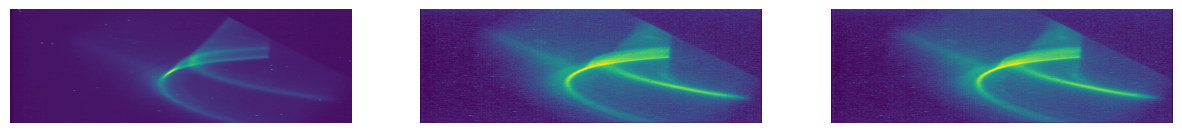

In [14]:
edit_img = frames_vid_aza[90].copy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(vid[90])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(frames_vid_aza[90])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(edit_aza[90])
plt.axis('off')
plt.show()

In [12]:
with open(f"../models/weighted_outer_all.pkl", 'rb') as f:
    model = pickle.load(f)

In [73]:
frames_vid_flatten = flatten(frames_vid)
prediction_cartesian_regression = model.predict(frames_vid_flatten)

NameError: name 'frames_vid' is not defined

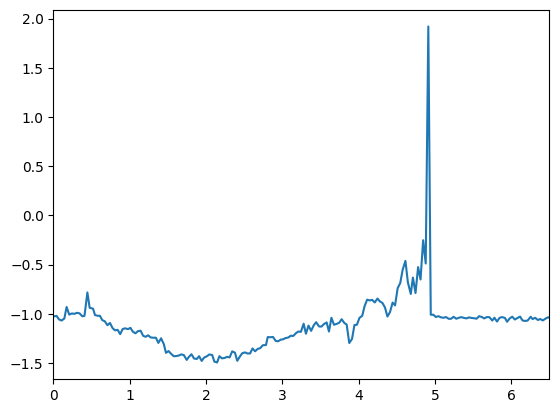

In [12]:
plt.plot(times_vid, prediction_cartesian_regression)
plt.xlim([0,6.5])
plt.show()

In [13]:
cnn_prediction = pickle.load(open(f"/scratch/gpfs/nc1514/plasma-tv/data/processed/weight_ml_point_aza/dltangtv_200759.pkl", 'rb'))

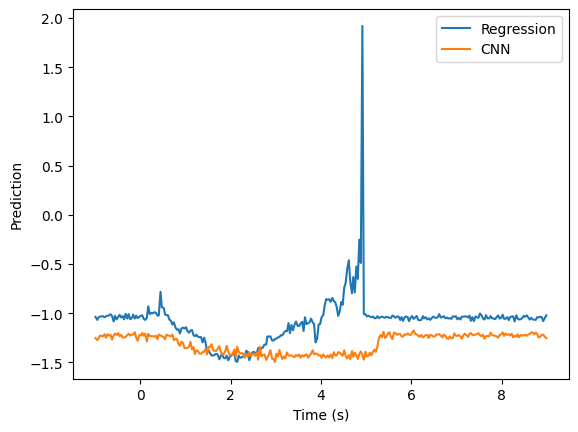

In [14]:
plt.plot(times_vid, prediction_cartesian_regression, label='Regression')
plt.plot(times_vid, cnn_prediction, label='CNN')
plt.xlabel('Time (s)')
plt.ylabel('Prediction')
plt.legend()
plt.show()

### End of Aza

In [15]:
scaling_factor = 10
radii_hires = np.linspace(radii[0][0],radii[0][-1],len(radii[0])*scaling_factor)
elevation_hires = np.linspace(elevation[0][0],elevation[0][-1],len(elevation[0])*scaling_factor)

In [16]:
pkl_path = '../data/external/toksearch/detach.pkl'

with open(pkl_path, 'rb') as file:
    points = pickle.load(file)

point_keys = list(points.keys())
shot = points[point_keys[file_idx]]['vars']
times = points[point_keys[file_idx]]['time']
times_transp = np.transpose(times)
shot_transp = np.transpose(shot)
print("Extracting pkl for shot: ", point_keys[file_idx])

Extracting pkl for shot:  189088


In [17]:
crop_times, crop_shot = crop_time(times_transp, shot_transp, inverted_times[0], inverted_times[-1])
rx = crop_shot[0] / 1e2
zx = crop_shot[1] / 1e2
rs = crop_shot[2] / 1e2
zs = crop_shot[3] / 1e2

interp_kind = 'linear'
rx_interp = interp1d(crop_times, rx, kind=interp_kind,fill_value='extrapolate')(inverted_times)
zx_interp = interp1d(crop_times, zx, kind=interp_kind,fill_value='extrapolate')(inverted_times)
rs_interp = interp1d(crop_times, rs, kind=interp_kind,fill_value='extrapolate')(inverted_times)
zs_interp = interp1d(crop_times, zs, kind=interp_kind,fill_value='extrapolate')(inverted_times)

In [18]:
rx_idx = get_index(rx_interp, radii_hires) / scaling_factor
zx_idx = get_index(zx_interp, elevation_hires) / scaling_factor
zs_idx = get_index(zs_interp, elevation_hires) / scaling_factor

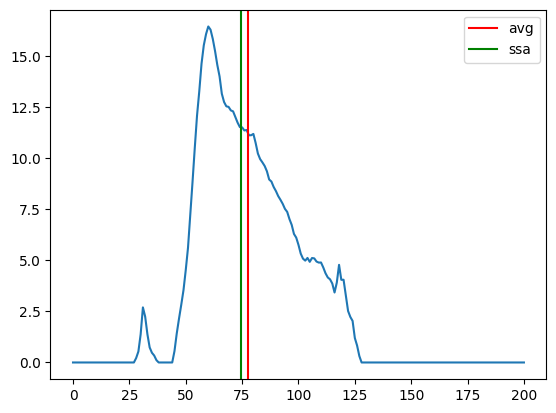

In [19]:
idx = 5
inverted_img = inverted[idx]
filter_img = (inverted_img > 0.1) * inverted_img
r = np.round(rx_idx[idx]).astype(int)
sum_outer = np.sum(filter_img[:,r:],axis=1)
indicies = np.arange(0, filter_img.shape[0])
weighted_sum = np.sum(indicies * sum_outer)
weighted_squre_sum = np.sum((indicies * sum_outer)**2)
total_weight = np.sum(sum_outer)
total_square_weight = np.sum(sum_outer**2)
avg = weighted_sum / total_weight
sqrt_sum_sq_avg = (weighted_squre_sum / total_square_weight)**0.5

plt.plot(sum_outer)
plt.axvline(avg,c='r', label='avg')
plt.axvline(sqrt_sum_sq_avg,c='g', label='ssa')
plt.legend()
plt.show()

In [20]:
z_arr_avg = []
z_arr_ssa = []
for idx, inverted_img in enumerate(inverted):
    filter_img = (inverted_img > 0.1) * inverted_img
    r = np.round(rx_idx[idx]).astype(int)
    sum_outer = np.sum(filter_img[:,r:],axis=1)
    indicies = np.arange(0, filter_img.shape[0])
    
    weighted_sum = np.sum(indicies * sum_outer)
    avg = np.divide(weighted_sum, np.sum(sum_outer), out=np.empty_like(weighted_sum), where=np.sum(sum_outer)!=0)
    z_arr_avg.append(avg)
    
    weighted_square_sum = np.sum((indicies * sum_outer)**2)
    total_square_weight = np.sum(sum_outer**2)
    sqrt_sum_sq_avg = np.divide(weighted_square_sum, total_square_weight, out=np.empty_like(weighted_square_sum), where=total_square_weight!=0)**0.5
    z_arr_ssa.append(sqrt_sum_sq_avg)

z_arr_avg = np.asarray(z_arr_avg)
z_arr_ssa = np.asarray(z_arr_ssa)
avg_avg_idx = np.mean(z_arr_avg)
ssa_avg_idx = np.mean(z_arr_ssa)
z_arr_avg[np.where(z_arr_avg == 0)[0]] = avg_avg_idx
z_arr_ssa[np.where(z_arr_ssa == 0)[0]] = ssa_avg_idx

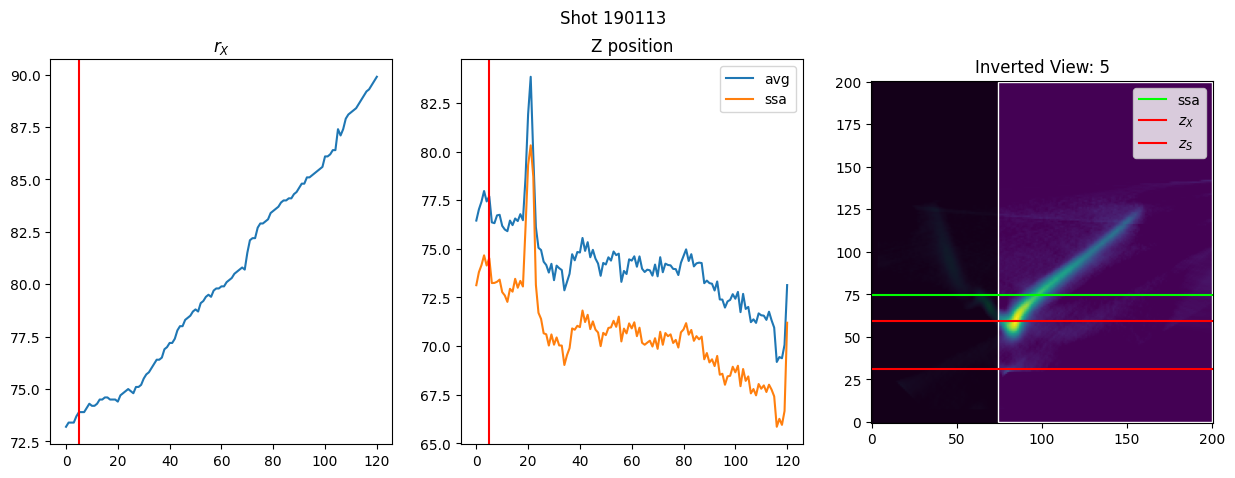

In [21]:
shot_length = inverted_dim[0]
idx = 5

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rect = patches.Rectangle((rx_idx[idx], 0), inverted_dim[1]-rx_idx[idx]-1, inverted_dim[2]-1, linewidth=1, edgecolor='w', facecolor='none')

ax_idx = 0
ax[ax_idx].plot(rx_idx)
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].set_title('$r_X$')

ax_idx = 1
ax[ax_idx].plot(z_arr_avg, label='avg')
ax[ax_idx].plot(z_arr_ssa, label='ssa')
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].legend(loc='upper right')
ax[ax_idx].set_title('Z position')

ax_idx = 2
ax[ax_idx].imshow(inverted[idx], origin='lower')
ax[ax_idx].axvspan(0, rx_idx[idx], color='black', alpha=0.7)
ax[ax_idx].set_title(f'Inverted View: {idx}')
ax[ax_idx].add_patch(rect)
ax[ax_idx].axhline(z_arr_ssa[idx],c='lime', label='ssa')
ax[ax_idx].axhline(zx_idx[idx],c='r', label='$z_X$')
ax[ax_idx].axhline(zs_idx[idx],c='r', label='$z_S$')
ax[ax_idx].legend(loc='upper right')

fig.suptitle(f"Shot {files[file_idx].stem.split('_')[-1]}")

fig.show()

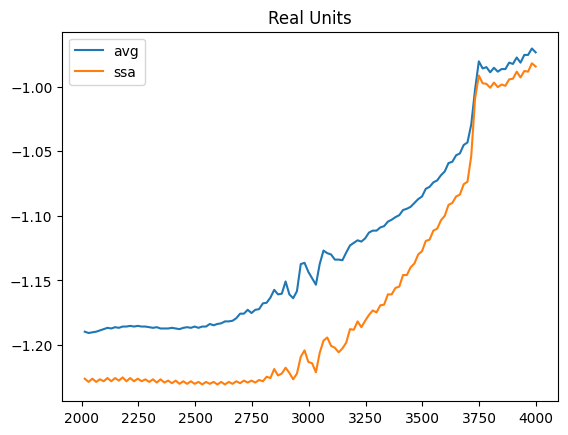

In [33]:
z_avg_rounds = [z*scaling_factor for z in z_arr_avg]
z_ssa_rounds = [z*scaling_factor for z in z_arr_ssa]

z_avg_real = elevation_hires[np.round(z_avg_rounds).astype(int)]
z_ssa_real = elevation_hires[np.round(z_ssa_rounds).astype(int)]

plt.plot(inverted_times,z_avg_real, label='avg')
plt.plot(inverted_times,z_ssa_real, label='ssa')
plt.title('Real Units')
plt.legend()
plt.show()

# System Identification
Do this after doing weighted_prediction_ml

In [34]:
value_path = Path('../data/processed/') / 'weight_ml_point'
pkl_files = sorted(value_path.glob('*.pkl'))
tv = GetTV('../data/raw/tv_images/all')
files = tv.list_files()
for idx, file in enumerate(pkl_files):
    print(idx, '\t', file.stem)

0 	 emission_structure_pu_cam240perp_189057
1 	 emission_structure_pu_cam240perp_189061
2 	 emission_structure_pu_cam240perp_189062
3 	 emission_structure_pu_cam240perp_189081
4 	 emission_structure_pu_cam240perp_189088
5 	 emission_structure_pu_cam240perp_189090
6 	 emission_structure_pu_cam240perp_189093
7 	 emission_structure_pu_cam240perp_189094
8 	 emission_structure_pu_cam240perp_189097
9 	 emission_structure_pu_cam240perp_189100
10 	 emission_structure_pu_cam240perp_189101
11 	 emission_structure_pu_cam240perp_189448
12 	 emission_structure_pu_cam240perp_189451
13 	 emission_structure_pu_cam240perp_190109
14 	 emission_structure_pu_cam240perp_190110
15 	 emission_structure_pu_cam240perp_190113
16 	 emission_structure_pu_cam240perp_190114
17 	 emission_structure_pu_cam240perp_190115
18 	 emission_structure_pu_cam240perp_190116
19 	 emission_structure_pu_cam240perp_199166
20 	 emission_structure_pu_cam240perp_199171
21 	 emission_structure_pu_cam240perp_199172
22 	 emission_struct

In [45]:
file_idx = 24

In [46]:
h5_path = '../data/external/toksearch/detach.h5'
shot = str(pkl_files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    print(file.keys())
    for key in file.keys():
        print(file[key].keys())
        break
    h5_times = file['times'][:]
    gasA = file[shot]['gasA'][:]
    gasB = file[shot]['gasB'][:]
    gasC = file[shot]['gasC'][:]
    dssdenest = file[shot]['dssdenest'][:]
    ip = file[shot]['ip'][:]
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()]
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    # dstradpg2 = file[shot]['dstradpg2'][:]

<KeysViewHDF5 ['189057', '189061', '189062', '189081', '189088', '189090', '189093', '189094', '189097', '189100', '189101', '189448', '189451', '190109', '190110', '190113', '190114', '190115', '190116', '195954', '195956', '195959', '195961', '195963', '199166', '199171', '199172', '199351', '199352', '199353', '199354', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['Ar_tot', 'D_tot', 'H_tot', 'He_tot', 'N_tot', 'Ne_tot', 'ZXPT1_EFIT01', 'betan_EFIT01', 'betap_EFIT01', 'bt', 'dssdene', 'dssdenest', 'dstradpg2', 'gasA', 'gasB', 'gasC', 'gas_sql', 'ip', 'ip_flat_duration_sql', 'pcphd03', 'q0_EFIT01', 'q95_EFIT01', 'qmin_EFIT01', 't_ip_flat_sql', 'thomson_density_psi_raw_1d', 'thomson_density_raw_1d', 'thomson_density_uncertainty_raw_1d', 'thomson_temp_psi_raw_1d', 'thomson_temp_raw_1d', 'thomson_temp_uncertainty_raw_1d', 'valve_sql']>


In [47]:
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

with open(pkl_files[file_idx], 'rb') as file:
    data = pickle.load(file)
    print(pkl_files[file_idx].stem)
    
# gotta manually find the location
cnn_prediction_data = pickle.load(open(f"/scratch/gpfs/nc1514/plasma-tv/data/processed/weight_ml_point/dl/dlemission_structure_pu_cam240perp_199353.pkl", 'rb')).reshape((1,-1))

emission_structure_pu_cam240perp_199353


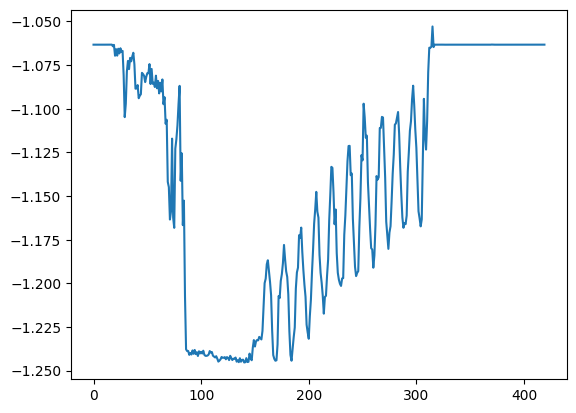

In [48]:
plt.plot(cnn_prediction_data[0])

In [61]:
t_start = t_ip_flat_sql
t_end = t_ip_flat_sql + ip_flat_duration_sql

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_gasA = crop_time(h5_times, gasA, t_start, t_end)
_, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_ip = crop_time(h5_times, ip, t_start, t_end)
_, crop_dssdenest = crop_time(h5_times, dssdenest, t_start, t_end)
crop_times, crop_data = crop_time(vid_times, data, t_start, t_end)
crop_inv_times, crop_prediction_data = crop_time(vid_times, cnn_prediction_data, t_start, t_end)

interp_kind = 'cubic'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_data = interp1d(crop_times, crop_data, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_data = interp1d(crop_inv_times, crop_prediction_data, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_gasA = interp1d(crop_h5_times, crop_gasA, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_ip = interp1d(crop_h5_times, crop_ip, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_dssdenest = interp1d(crop_h5_times, crop_dssdenest, kind=interp_kind, fill_value='extrapolate')(t_grid)

gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz = (interp_ZXPT - interp_data) / (interp_ZXPT - interp_ZStrike) + interp_ZStrike
Dz_PID = Dz[0]
Dz_predict_PID = ((interp_ZXPT - interp_prediction_data) / (interp_ZXPT - interp_ZStrike) + interp_ZStrike)[0]

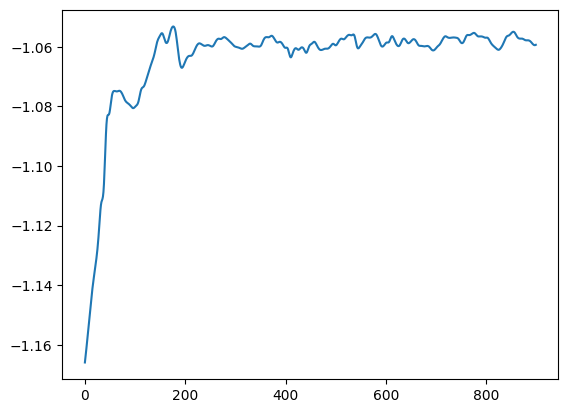

In [62]:
plt.plot(interp_ZXPT[0][:-100])

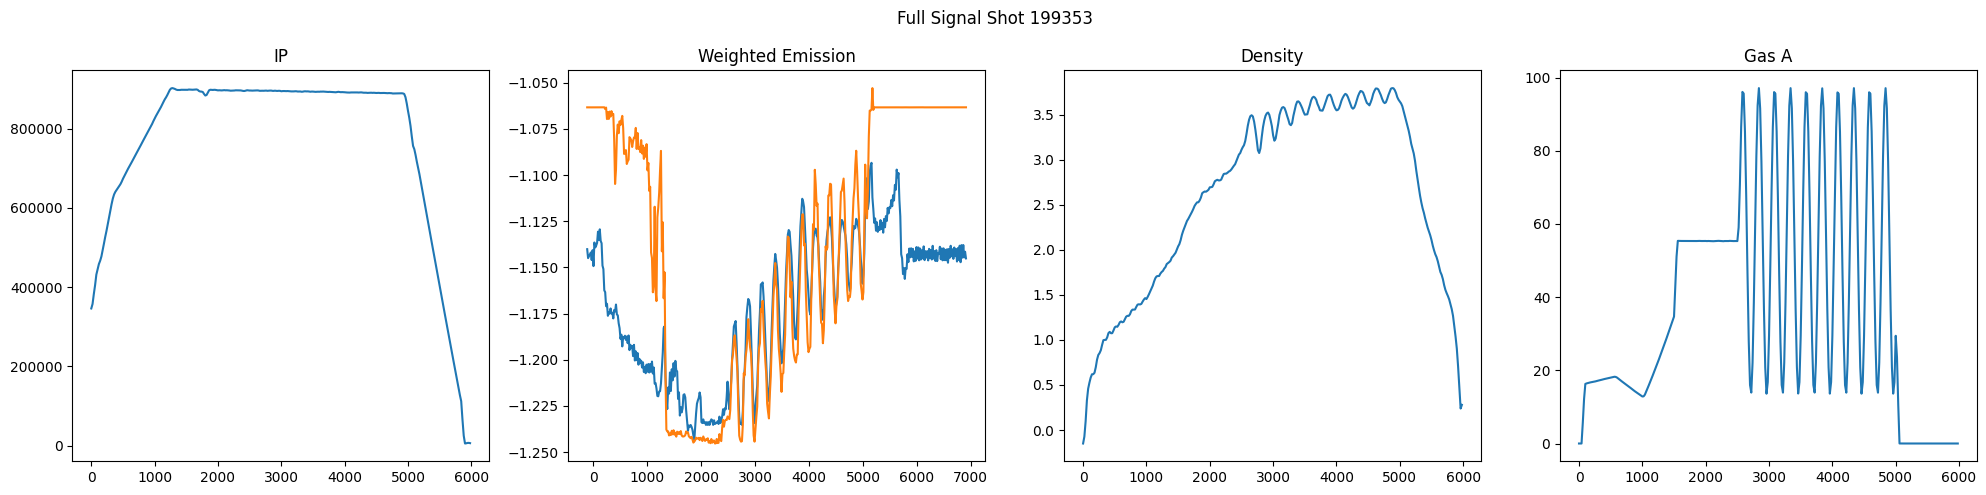

In [63]:
plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.plot(h5_times, ip)
plt.title('IP')

plt.subplot(1, 4, 2)
plt.plot(vid_times,data)
plt.plot(vid_times,cnn_prediction_data[0])
plt.title('Weighted Emission')

plt.subplot(1, 4, 3)
plt.plot(h5_times, dssdenest)
plt.title('Density')

plt.subplot(1, 4, 4)
plt.plot(h5_times, gasA)
plt.title('Gas A')

plt.suptitle(f"Full Signal Shot {shot}")
plt.tight_layout()

plt.show()

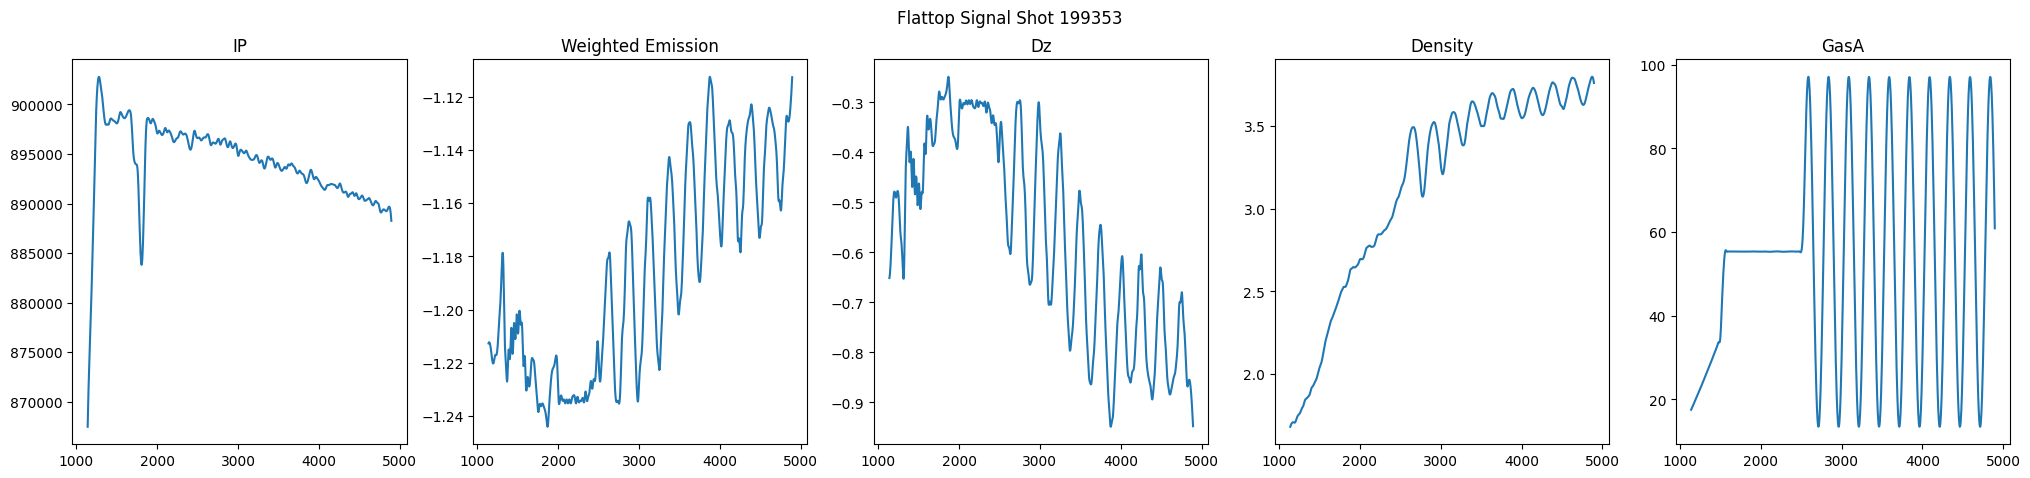

In [64]:
plt.figure(figsize=(25,5))
plt.subplot(1, 5, 2)
plt.plot(t_grid,interp_data[0], label='label')
# plt.plot(t_grid,interp_prediction_data[0], label='prediction')
# plt.legend()
plt.title('Weighted Emission')
plt.subplot(1, 5, 4)
plt.plot(t_grid, interp_dssdenest[0])
plt.title('Density')
plt.subplot(1, 5, 5)
plt.plot(t_grid, gasA_PID)
plt.title('GasA')
plt.subplot(1, 5, 3)
plt.plot(t_grid, Dz_PID, label='label')
# plt.plot(t_grid, Dz_predict_PID, label='prediction')
# plt.legend()
plt.title('Dz')
plt.subplot(1, 5, 1)
plt.plot(t_grid, interp_ip[0])
plt.title('IP')
plt.suptitle('Flattop Signal Shot ' + shot)
plt.tight_layout
plt.show()

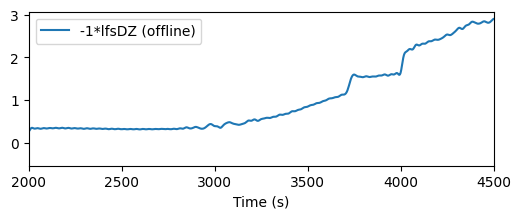

In [43]:
plt.figure(figsize=(6,2))
plt.plot(t_grid,-Dz_PID,label='-1*lfsDZ (offline)')
plt.xlabel('Time (s)')
# plt.ylabel('Dz')
plt.xlim(2000,4500)
plt.legend()
plt.show()

In [45]:
txt_file = (Path('../data/processed/weight_ml_point') / files[file_idx].stem.split('_')[-1]).with_suffix('.txt')
with open(txt_file, 'w') as f:
    for idx, point in enumerate(gasA_PID):
        f.write(f"{t_grid[idx]}, {Dz_PID[idx]}, {point}\n")
print(f"Saved {txt_file}")

Saved ../data/processed/weight_ml_point/199353.txt
